<a href="https://colab.research.google.com/github/ivydiana/DS-Record/blob/main/a1_a1_1_Group159_530147688_540862722.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.datasets import load_digits
import tensorflow as tf
from tensorflow.keras import layers, models

Load dataset

In [109]:
# Load the datasets
data_train_df = pd.read_csv('/content/train.csv', na_values=['', 'NA', None])
data_test_df = pd.read_csv('/content/test1.csv', na_values=['', 'NA', None])
data_test_df_2 = pd.read_csv('/content/test2.csv', index_col=0, na_values=['', 'NA', None])

# Prepare features and labels
X_train_1 = data_train_df.loc[:, "v1":"v784"].to_numpy()
Y_train_1 = data_train_df['label'].to_numpy()

# X_test and Y_test
X_test = data_test_df.loc[:, "v1":"v784"].to_numpy()
Y_test = data_test_df['label'].to_numpy()

# X_test_2
X_test_2 = data_test_df_2.loc[:, "v1":"v784"].to_numpy()

# Split the training data into training and validation.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_1, Y_train_1, test_size=0.2, random_state=42)

Data Proprecessing: Normalize and ANN

In [110]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)
x_test_2_scaled = scaler.transform(X_test_2)
X_val_scaled = scaler.transform(X_val)

# Define input dimension(here we set same dimension like original data dimension)）
input_dim = x_scaled.shape[1]

# Compressed 64 dimensions
encoding_dim = 64
input_layer = layers.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Compiling and training the autoencoder
autoencoder = models.Model(input_layer, decoded)
encoder = models.Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_scaled, x_scaled, epochs=50, batch_size=256, shuffle=True)

# Extracting low-dimensional features
x_encoded = encoder.predict(x_scaled)
x_test_encoded = encoder.predict(x_test_scaled)
x_test_encoded_2 = encoder.predict(x_test_2_scaled)
x_valid_encoded = encoder.predict(X_val_scaled)
print(x_encoded.shape)

Epoch 1/50
94/94 [==============================] - 1s 7ms/step - loss: 0.8215
Epoch 2/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6702
Epoch 3/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6480
Epoch 4/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6367
Epoch 5/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6296
Epoch 6/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6247
Epoch 7/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6210
Epoch 8/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6179
Epoch 9/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6154
Epoch 10/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6132
Epoch 11/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6115
Epoch 12/50
94/94 [==============================] - 1s 6ms/step - loss: 0.6098
Epoch 13/50
94/94 [==============================

Model 1: KNN

Hyperparameter tuning:
1. n_neighbors: [1, 3, 5, 7, 9, 11]
2. p: [1, 2]  # p=1: Manhattan distance, p=2: Euclidean distance

Best parameter: {'n_neighbors': 5, 'p': 2}
Best score: 0.8531

Best parameters: {'n_neighbors': 5, 'p': 2}
Best cross validation score: 0.8512
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       191
           1       0.99      0.98      0.98       199
           2       0.77      0.80      0.79       191
           3       0.87      0.90      0.89       174
           4       0.80      0.84      0.82       203
           5       0.96      0.85      0.90       210
           6       0.70      0.59      0.64       201
           7       0.87      0.93      0.90       212
           8       0.99      0.94      0.96       216
           9       0.89      0.93      0.91       203

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



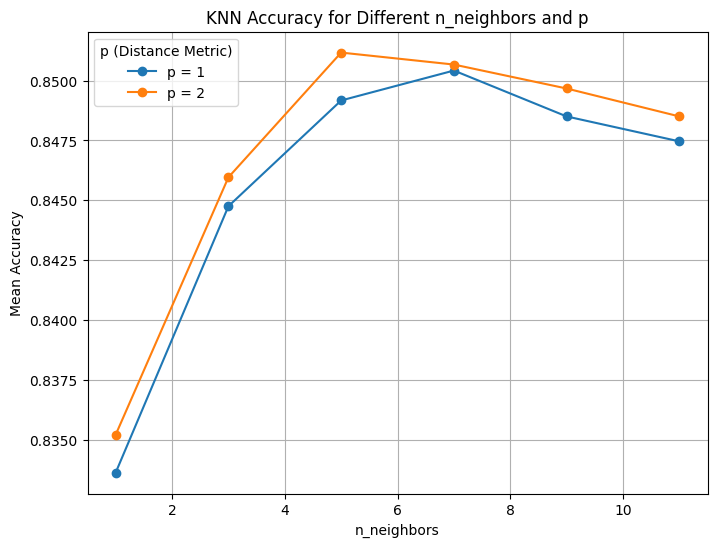

In [111]:
# KNN: Parameter-Grid
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    # p=1: Manhattan distance, p=2: Euclidean distance
    'p': [1, 2]
}

knn = KNeighborsClassifier()

# GridSearchCV function: Hyperparameter search
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(x_encoded, Y_train)

# Acquire best estimator
best_knn = grid_search_knn.best_estimator_

# Predict on the test set
y_pred_knn = best_knn.predict(x_test_encoded)

# Display best parameters and corresponding accuracy
print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Best cross validation score: {grid_search_knn.best_score_:.4f}")

# Print detailed classification report
print("Classification report:")
print(classification_report(Y_test, y_pred_knn))

# Get cross-validation results
results_knn = grid_search_knn.cv_results_

# Select n_neighbors and p parameter, and their mean_test_score
neighbors = results_knn['param_n_neighbors'].data
distances = results_knn['param_p'].data
scores = results_knn['mean_test_score']

# Transform data type
neighbors = np.array(neighbors, dtype=int)
distances = np.array(distances, dtype=int)
scores = np.array(scores)

# Plot KNN Accuracy for Different n_neighbors and p
plt.figure(figsize=(8, 6))

# Plot for all different p values
for distance in np.unique(distances):
    mask = distances == distance
    plt.plot(neighbors[mask], scores[mask], label=f'p = {distance}', marker='o')

plt.title("KNN Accuracy for Different n_neighbors and p")
plt.xlabel("n_neighbors")
plt.ylabel("Mean Accuracy")
plt.legend(title="p (Distance Metric)")
plt.grid(True)
plt.show()

In [112]:
# Calculate KNN performance metrics
accuracy_knn = accuracy_score(Y_test, y_pred_knn)
f1_knn = f1_score(Y_test, y_pred_knn, average='weighted')
precision_knn = precision_score(Y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(Y_test, y_pred_knn, average='weighted')
cm_knn = confusion_matrix(Y_test, y_pred_knn)

#print performance metrics results
print(f"Accuracy (KNN): {accuracy_knn:.4f}")
print(f"F1 Score (KNN, Weighted): {f1_knn:.4f}")
print(f"Precision (KNN, Weighted): {precision_knn:.4f}")
print(f"Recall (KNN, Weighted): {recall_knn:.4f}")
print("Confusion Matrix (KNN):")
print(cm_knn)

Accuracy (KNN): 0.8625
F1 Score (KNN, Weighted): 0.8615
Precision (KNN, Weighted): 0.8631
Recall (KNN, Weighted): 0.8625
Confusion Matrix (KNN):
[[163   1   1   6   0   0  17   0   2   1]
 [  1 195   0   3   0   0   0   0   0   0]
 [  4   0 153   3  21   0  10   0   0   0]
 [  3   1   2 157   8   0   3   0   0   0]
 [  0   0  11   6 170   0  16   0   0   0]
 [  0   0   0   1   0 179   0  17   0  13]
 [ 37   0  28   2  14   0 119   0   1   0]
 [  0   0   0   0   0   4   0 198   0  10]
 [  1   0   3   2   0   1   5   2 202   0]
 [  0   0   0   0   0   3   0  11   0 189]]


Model 2. SVM

Hyperparameter tuning:
kernel: ['poly','rbf'],
gamma: ['scale', 'auto'],
C: [0.01, 0.1, 1, 10, 50]

Best parameter: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameter: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross validation score: 0.8791
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       191
           1       0.99      0.98      0.99       199
           2       0.83      0.81      0.82       191
           3       0.85      0.91      0.88       174
           4       0.85      0.88      0.87       203
           5       0.98      0.93      0.96       210
           6       0.80      0.72      0.76       201
           7       0.91      0.95      0.93       212
           8       0.96      0.97      0.97       216
           9       0.93      0.94      0.93       203

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



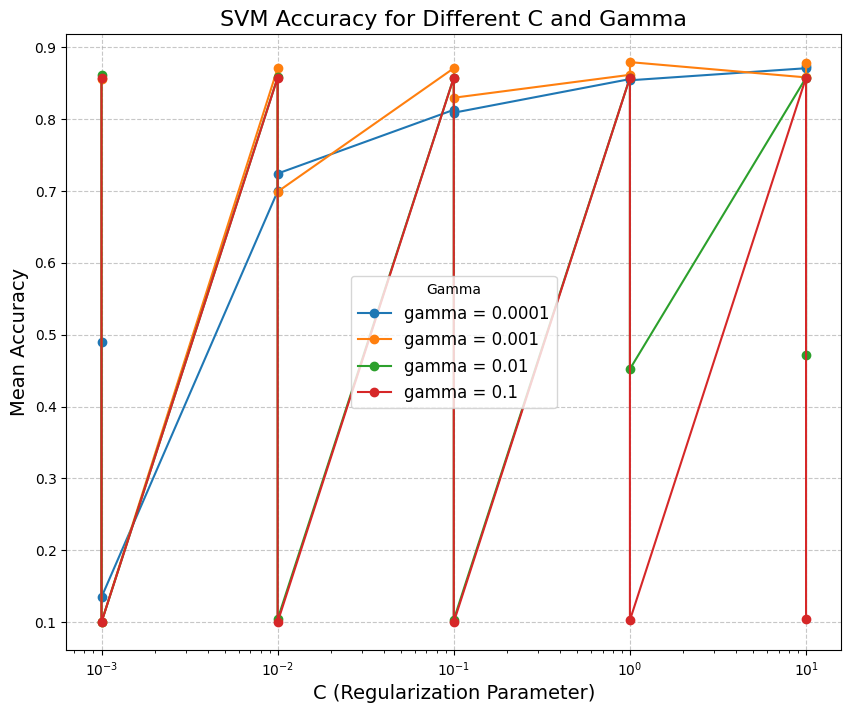

In [113]:
svm_model = SVC(class_weight='balanced')

# Define the hyperparameter grid to search
param_grid = [{'kernel': ['poly','rbf'],
               'gamma': [0.0001, 0.001, 0.01, 0.1],
               'C': [0.001, 0.01, 0.1, 1, 10]}
             ]

# GridSearchCV function:Hyperparameter search,n_jobs:Reduce training time
grid_search_svm = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(x_encoded, Y_train)

# Using best model to predict test set and acquire best parameter performance metrics.
best_svm_model = grid_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(x_test_encoded)

#Print SVM best parameter
print(f"Best parameter: {grid_search_svm.best_params_}")
print(f"Best cross validation score: {grid_search_svm.best_score_:.4f}")

# Get classification report
print("Classification report:")
print(classification_report(Y_test, y_pred_svm))

# select GridSearchCV result
results_svm = grid_search_svm.cv_results_

# select C and gamma parameter and their's mean_test_score
c_values = results_svm['param_C'].data
gamma_values = results_svm['param_gamma'].data
scores = results_svm['mean_test_score']

# transform type
c_values = np.array(c_values, dtype=float)
gamma_values = np.array(gamma_values, dtype=str)
scores = np.array(scores)

# Figure
plt.figure(figsize=(10, 8))

# find all different gamma value
for gamma in np.unique(gamma_values):
    mask = gamma_values == gamma
    plt.plot(c_values[mask], scores[mask], label=f'gamma = {gamma}', marker='o')

plt.title("SVM Accuracy for Different C and Gamma", fontsize=16)
plt.xlabel("C (Regularization Parameter)", fontsize=14)
plt.ylabel("Mean Accuracy", fontsize=14)
plt.xscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Gamma", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [114]:
# SVM performance metrics
accuracy_svm = accuracy_score(Y_test, y_pred_svm)
f1_svm = f1_score(Y_test, y_pred_svm, average='weighted')
precision_svm = precision_score(Y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(Y_test, y_pred_svm, average='weighted')
cm_svm = confusion_matrix(Y_test, y_pred_svm)

#print performance metrics results
print(f"Accuracy (SVM): {accuracy_svm:.4f}")
print(f"F1 Score (SVM, Weighted): {f1_svm:.4f}")
print(f"Precision (SVM, Weighted): {precision_svm:.4f}")
print(f"Recall (SVM, Weighted): {recall_svm:.4f}")
print("Confusion Matrix (SVM):")
print(cm_svm)

Accuracy (SVM): 0.8975
F1 Score (SVM, Weighted): 0.8969
Precision (SVM, Weighted): 0.8973
Recall (SVM, Weighted): 0.8975
Confusion Matrix (SVM):
[[165   0   2   8   0   1  12   0   3   0]
 [  0 196   0   3   0   0   0   0   0   0]
 [  3   0 154   3  18   0  11   0   2   0]
 [  1   2   2 159   6   0   4   0   0   0]
 [  0   0   8   8 179   0   8   0   0   0]
 [  0   0   0   1   0 196   0   8   0   5]
 [ 25   0  18   4   7   0 144   0   3   0]
 [  0   0   0   0   0   0   0 202   0  10]
 [  0   0   2   2   0   1   1   0 210   0]
 [  0   0   0   0   0   1   0  12   0 190]]


Model 3. Decision Tree

Hypermeter tuning:
'criterion': ['gini', 'entropy'],  # Removed 'log_loss' for speed(the accuracy is too low)
'max_depth': [5,10,15,20,25, None],  
'min_samples_split': [2, 5, 10],  
'min_samples_leaf': [1, 2, 4],  
'max_features': [None]  

Best parameter: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

Best parameter: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross validation score: 0.7316
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       191
           1       0.91      0.93      0.92       199
           2       0.61      0.63      0.62       191
           3       0.75      0.74      0.74       174
           4       0.59      0.71      0.64       203
           5       0.81      0.74      0.77       210
           6       0.48      0.35      0.41       201
           7       0.78      0.86      0.82       212
           8       0.89      0.82      0.86       216
           9       0.90      0.82      0.86       203

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



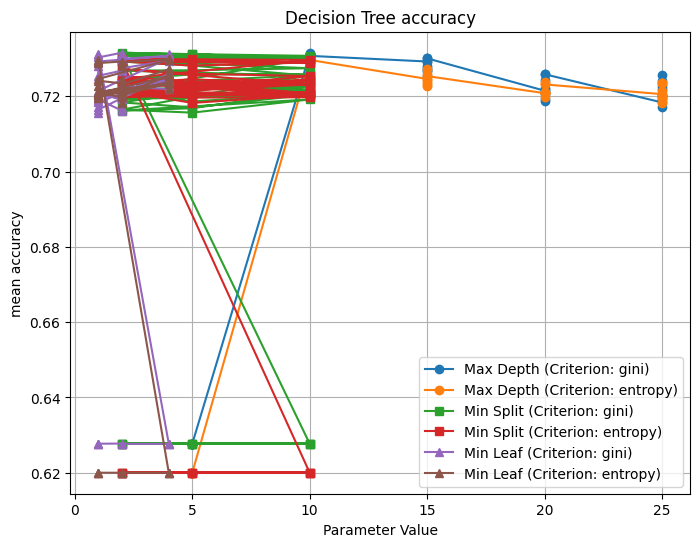

In [115]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10,15,20,25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None]
}

# Define decision tree model
dt_model = DecisionTreeClassifier()

# GridSearchCV function:Hyperparameter search
# n_jobs:Reduce training time
grid_search_dt = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(x_encoded, Y_train)

# Print DT best parameter
print(f"Best parameter: {grid_search_dt.best_params_}")
print(f"Best cross validation score: {grid_search_dt.best_score_:.4f}")

# Use best predict model
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(x_test_encoded)


# Output classification report and accuracy
print("Classification Report:")
print(classification_report(Y_test, y_pred_dt))

#Decision tree plot
results_dt = grid_search_dt.cv_results_

scores = results_dt['mean_test_score']
max_depth_values = results_dt['param_max_depth']
min_samples_split_values = results_dt['param_min_samples_split']
min_samples_leaf_values = results_dt['param_min_samples_leaf']
criterion_values = results_dt['param_criterion']

plt.figure(figsize=(8, 6))
for criterion in ['gini', 'entropy']:
    mask = criterion_values == criterion
    plt.plot(max_depth_values[mask], scores[mask], marker='o', label=f'Max Depth (Criterion: {criterion})')
for criterion in ['gini', 'entropy']:
    mask = criterion_values == criterion
    plt.plot(min_samples_split_values[mask], scores[mask], marker='s', label=f'Min Split (Criterion: {criterion})')
for criterion in ['gini', 'entropy']:
    mask = criterion_values == criterion
    plt.plot(min_samples_leaf_values[mask], scores[mask], marker='^', label=f'Min Leaf (Criterion: {criterion})')
plt.title('Decision Tree accuracy')
plt.xlabel('Parameter Value')
plt.ylabel('mean accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [116]:
#DT:performance metrics
accuracy_dt = accuracy_score(Y_test, y_pred_dt)
f1_dt = f1_score(Y_test, y_pred_dt, average='weighted')
precision_dt = precision_score(Y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(Y_test, y_pred_dt, average='weighted')
cm_dt = confusion_matrix(Y_test, y_pred_dt)

#print performance metrics results
print(f"Accuracy (DT): {accuracy_dt:.4f}")
print(f"F1 Score (DT, Weighted): {f1_dt:.4f}")
print(f"Precision (DT, Weighted): {precision_dt:.4f}")
print(f"Recall (DT, Weighted): {recall_dt:.4f}")
print("Confusion Matrix (DT):")
print(cm_dt)

Accuracy (DT): 0.7405
F1 Score (DT, Weighted): 0.7379
Precision (DT, Weighted): 0.7406
Recall (DT, Weighted): 0.7405
Confusion Matrix (DT):
[[147   3   5   9   1   0  22   0   4   0]
 [  3 185   0   6   3   0   2   0   0   0]
 [  5   1 121   4  39   0  19   1   1   0]
 [ 11   6   5 129  10   1   8   0   4   0]
 [  4   3  24   9 144   0  18   0   1   0]
 [  3   4   3   3   2 156   0  28   5   6]
 [ 41   1  34   6  43   0  71   0   5   0]
 [  0   0   0   0   0  18   0 183   0  11]
 [  4   1   5   5   4   6   8   4 178   1]
 [  0   0   0   2   0  12   0  20   2 167]]


Model 4. Logistic Regression

  Paramater:  
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],  
    'solver': ['saga']
  Best parameter:
{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

Best Parameter: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best cross validation score: 0.8350
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       191
           1       0.96      0.97      0.97       199
           2       0.77      0.76      0.76       191
           3       0.86      0.85      0.85       174
           4       0.79      0.80      0.79       203
           5       0.95      0.84      0.89       210
           6       0.69      0.64      0.67       201
           7       0.86      0.92      0.89       212
           8       0.94      0.94      0.94       216
           9       0.89      0.94      0.91       203

    accuracy                           0.86      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.86      0.86      0.85      2000



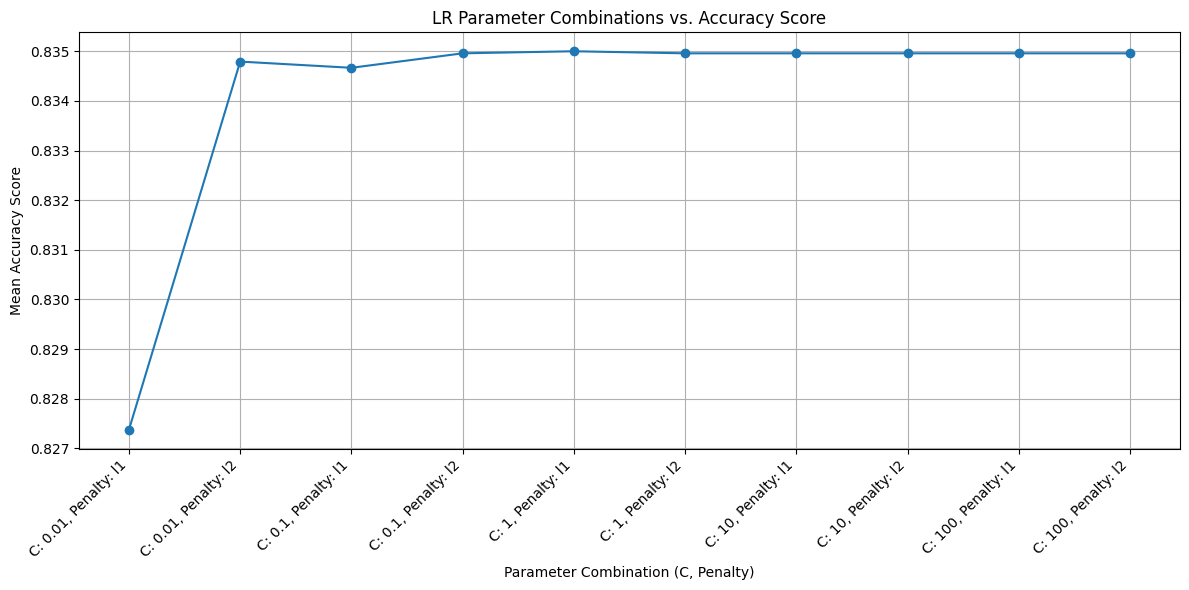

In [117]:
# Define logistic regression model
lr_model = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization Type
    'solver': ['saga']
}

# Perform grid search
grid_search_lr = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(x_encoded, Y_train)

# Use the best parameter model to train
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(x_test_encoded)

# Print best parameter
print(f"Best Parameter: {grid_search_lr.best_params_}")
print(f"Best cross validation score: {grid_search_lr.best_score_:.4f}")
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(Y_test, y_pred_lr))

# Extract grid search results
results_lr = grid_search_lr.cv_results_

# Extract mean test scores for each parameter combination
mean_test_scores = results_lr['mean_test_score']
param_C = results_lr['param_C']
param_penalty = results_lr['param_penalty']

# Convert parameters to a string format for better visualization
param_combinations = [f"C: {c}, Penalty: {p}" for c, p in zip(param_C, param_penalty)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(param_combinations, mean_test_scores, marker='o', linestyle='-')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Parameter Combination (C, Penalty)')
plt.ylabel('Mean Accuracy Score')
plt.title('LR Parameter Combinations vs. Accuracy Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [119]:
# Calculate metrics
accuracy_lr = accuracy_score(Y_test, y_pred_lr)
f1_lr = f1_score(Y_test, y_pred_lr, average='weighted')
precision_lr = precision_score(Y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(Y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(Y_test, y_pred_lr)

#print performance metrics results
print(f"Accuracy (lr): {accuracy_lr:.4f}")
print(f"F1 Score (lr, Weighted): {f1_lr:.4f}")
print(f"Precision (lr, Weighted): {precision_lr:.4f}")
print(f"Recall (lr, Weighted): {recall_lr:.4f}")
print("Confusion Matrix (lr):")
print(cm_lr)

Accuracy (lr): 0.8555
F1 Score (lr, Weighted): 0.8546
Precision (lr, Weighted): 0.8552
Recall (lr, Weighted): 0.8555
Confusion Matrix (lr):
[[170   0   0   7   0   0  11   0   2   1]
 [  0 194   1   4   0   0   0   0   0   0]
 [  3   1 145   3  23   0  14   0   2   0]
 [  2   7   2 148   9   0   5   0   1   0]
 [  0   0  13   6 162   0  21   1   0   0]
 [  1   0   0   1   0 176   0  18   4  10]
 [ 28   1  27   2  11   0 129   0   3   0]
 [  0   0   0   0   0   6   0 194   0  12]
 [  1   0   1   2   0   3   6   0 203   0]
 [  0   0   0   0   0   1   0  12   0 190]]


Bagging

Parameter:    
    'n_estimators': [5, 10, 20],               
    'max_samples': [0.7, 0.8, 1.0],              
    'max_features': [0.7, 0.8, 1.0]
Best estimator:
{'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 20}

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best parameters from GridSearchCV: {'base_estimator__C': 3, 'base_estimator__gamma': 0.001, 'base_estimator__kernel': 'rbf', 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 10}
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       191
           1       0.98      0.98      0.98       199
           2       0.82      0.80      0.81       191
           3       0.85      0.94      0.89       174
           4       0.85      0.86      0.86       203
           5       0.99      0.92      0.95       210
           6       0.79      0.70      0.74       201
           7       0.91      0.95      0.93       212
           8       0.97      0.96      0.97       216
           9       0.93      0.94      0.93       203

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



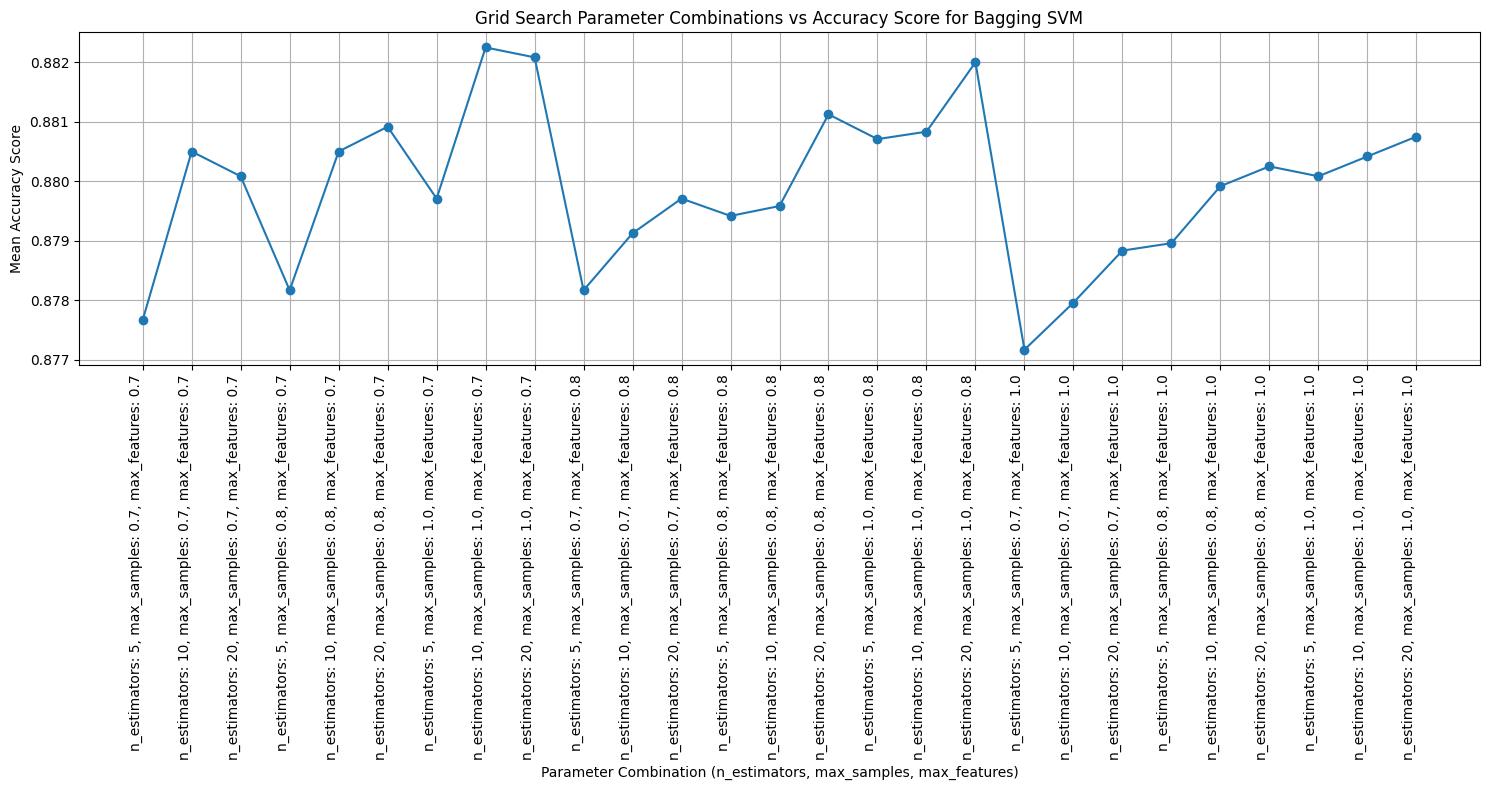

In [120]:
# Define parameter grid
param_grid = {
    'base_estimator__C': [3],           # SVM best parameters
    'base_estimator__gamma': [0.001],   # SVM best parameters
    'base_estimator__kernel': ['rbf'],  # SVM best parameters
    'n_estimators': [5, 10, 20],        # Bagging parameter: # of base estimators
    'max_samples': [0.7, 0.8, 1.0],     # Bagging parameter: fraction of samples to train estimator
    'max_features': [0.7, 0.8, 1.0]     # Bagging parameter
}

# Bagging with the base SVM classifier
svm = SVC(class_weight='balanced')
bagging_svm = BaggingClassifier(base_estimator=svm, random_state=42)

# Perform Grid Search on Bagging parameters
grid_search_bagging = GridSearchCV(bagging_svm, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_bagging.fit(x_encoded, Y_train)
print("Best parameters from GridSearchCV:", grid_search_bagging.best_params_)

# Search the best model
svm_best = grid_search_bagging.best_estimator_

# Predict on the test set
y_pred_bagging = svm_best.predict(x_test_encoded)

# Print classification report and accuracy score
print("Classification report:")
print(classification_report(Y_test, y_pred_bagging))

# Grid search results
results_bagging = grid_search_bagging.cv_results_

# Test scores for each parameter combination
mean_test_scores = results_bagging['mean_test_score']
param_n_estimators = results_bagging['param_n_estimators']
param_max_samples = results_bagging['param_max_samples']
param_max_features = results_bagging['param_max_features']

# Convert parameters to the string format.
param_combinations = [f"n_estimators: {n}, max_samples: {s}, max_features: {f}"
                      for n, s, f in zip(param_n_estimators, param_max_samples, param_max_features)]

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(param_combinations, mean_test_scores, marker='o', linestyle='-')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Parameter Combination (n_estimators, max_samples, max_features)')
plt.ylabel('Mean Accuracy Score')
plt.title('Grid Search Parameter Combinations vs Accuracy Score for Bagging SVM')
plt.grid(True)
plt.tight_layout()
plt.show()

In [121]:
accuracy_bagging = accuracy_score(Y_test, y_pred_bagging)
f1_bagging = f1_score(Y_test, y_pred_bagging, average='weighted')
precision_bagging = precision_score(Y_test, y_pred_bagging, average='weighted')
recall_bagging = recall_score(Y_test, y_pred_bagging, average='weighted')
cm_bagging = confusion_matrix(Y_test, y_pred_bagging)

#print performance metrics results
print(f"Accuracy (bagging): {accuracy_bagging:.4f}")
print(f"F1 Score (bagging, Weighted): {f1_bagging:.4f}")
print(f"Precision (bagging, Weighted): {precision_bagging:.4f}")
print(f"Recall (bagging, Weighted): {recall_bagging:.4f}")
print("Confusion Matrix (bagging):")
print(cm_bagging)

Accuracy (bagging): 0.8945
F1 Score (bagging, Weighted): 0.8938
Precision (bagging, Weighted): 0.8946
Recall (bagging, Weighted): 0.8945
Confusion Matrix (bagging):
[[169   0   1   7   0   1  11   0   2   0]
 [  0 196   0   3   0   0   0   0   0   0]
 [  2   0 153   4  17   0  13   0   2   0]
 [  1   3   1 163   4   0   2   0   0   0]
 [  0   0  12   7 175   0   9   0   0   0]
 [  1   0   0   1   0 193   0   9   1   5]
 [ 27   0  18   5  10   0 140   0   1   0]
 [  0   0   0   0   0   0   0 202   0  10]
 [  2   0   1   2   0   1   3   0 207   0]
 [  0   0   0   0   0   0   0  12   0 191]]


Evaluation

Evaluate the best version of each model using appropriate
classifi cation performance metrics onthe validation set and test on
test1.csv
. Ensure that the results are visualized using high-qualityplots, fi gures, or tables to clearly demonstrate model performance.

In [122]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, p=2)
knn.fit(x_valid_encoded, Y_val)

# SVM
svm = SVC(C=1, gamma=0.001, kernel='rbf', probability=True)
svm.fit(x_valid_encoded, Y_val)

# Decision Tree
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=5)
decision_tree.fit(x_valid_encoded, Y_val)

# Logistic Regression
lr = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=1000)
lr.fit(x_valid_encoded, Y_val)

# Bagging model based on SVM
bagging_svm = BaggingClassifier(estimator=svm, n_estimators=10, max_samples=1.0, max_features=0.8, random_state=42, n_jobs=-1)
bagging_svm.fit(x_valid_encoded, Y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


BaggingClassifier(estimator=SVC(C=1, gamma=0.001, probability=True),
                  max_features=0.8, n_jobs=-1, random_state=42)

Performance for KNN on Validation Set:
Accuracy: 0.8582, Precision: 0.8577, Recall: 0.8582, F1 Score: 0.8573
Training Time: 0.0043s, Inference Time (Validation): 0.2496s
Performance for KNN on Test Set:
Accuracy: 0.8625, Precision: 0.8631, Recall: 0.8625, F1 Score: 0.8615
Inference Time (Test): 0.0342s


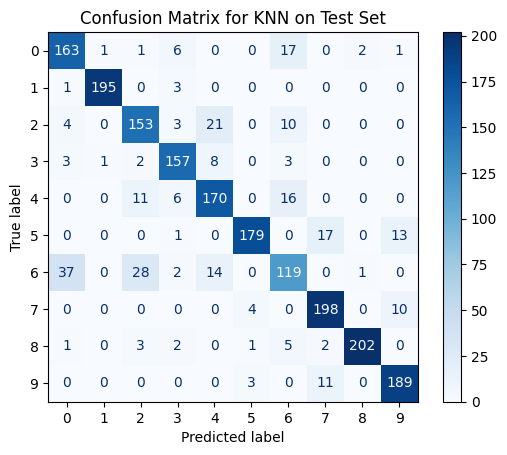

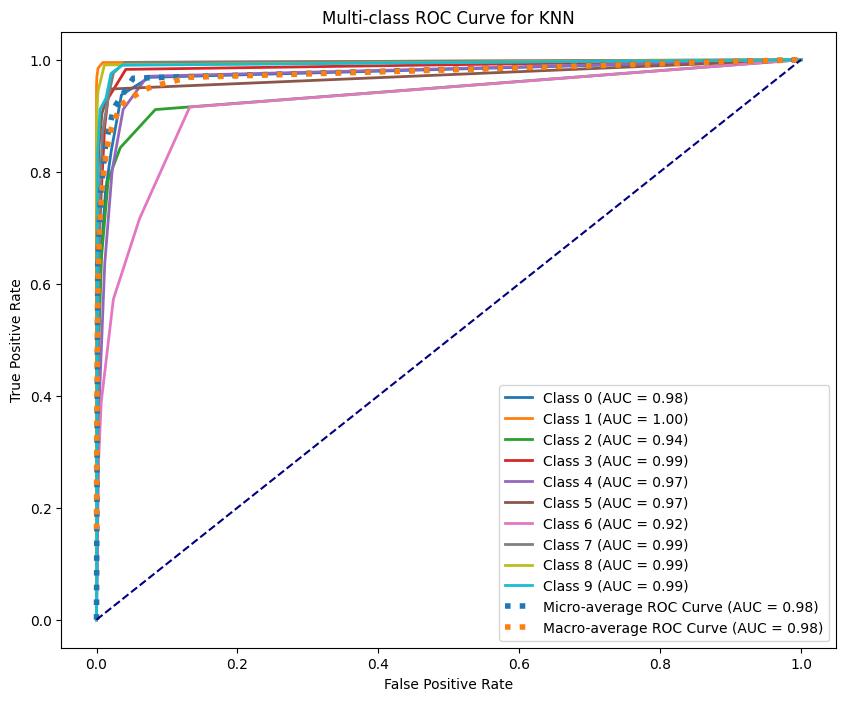

Performance for SVM on Validation Set:
Accuracy: 0.8850, Precision: 0.8846, Recall: 0.8850, F1 Score: 0.8846
Training Time: 89.7291s, Inference Time (Validation): 5.9528s
Performance for SVM on Test Set:
Accuracy: 0.8990, Precision: 0.8990, Recall: 0.8990, F1 Score: 0.8986
Inference Time (Test): 1.7459s


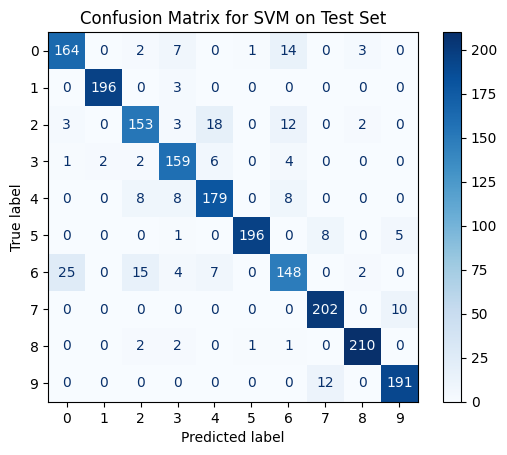

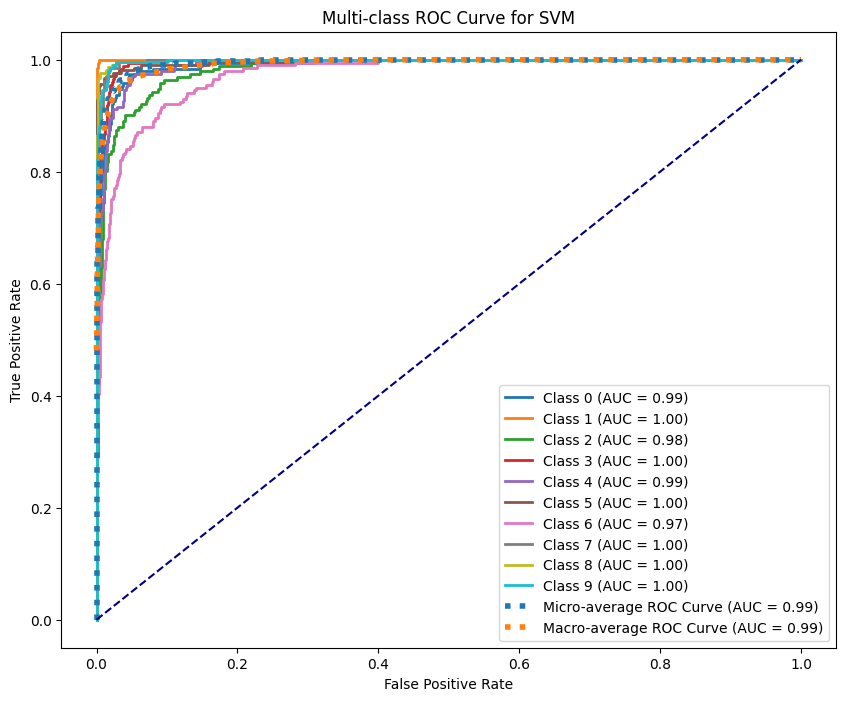

Performance for Decision Tree on Validation Set:
Accuracy: 0.7412, Precision: 0.7417, Recall: 0.7412, F1 Score: 0.7409
Training Time: 4.6083s, Inference Time (Validation): 0.0014s
Performance for Decision Tree on Test Set:
Accuracy: 0.7430, Precision: 0.7396, Recall: 0.7430, F1 Score: 0.7399
Inference Time (Test): 0.0006s


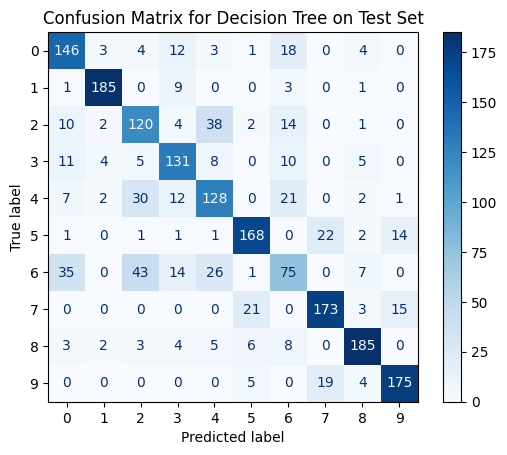

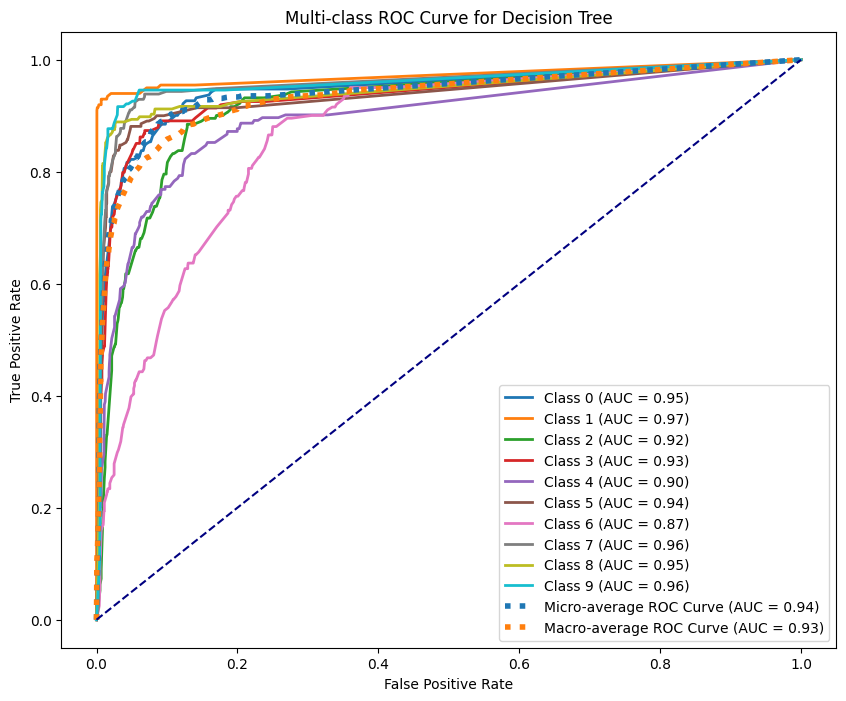

Performance for Logistic Regression on Validation Set:
Accuracy: 0.8465, Precision: 0.8461, Recall: 0.8465, F1 Score: 0.8461
Training Time: 57.7654s, Inference Time (Validation): 0.0018s
Performance for Logistic Regression on Test Set:
Accuracy: 0.8555, Precision: 0.8552, Recall: 0.8555, F1 Score: 0.8547
Inference Time (Test): 0.0006s


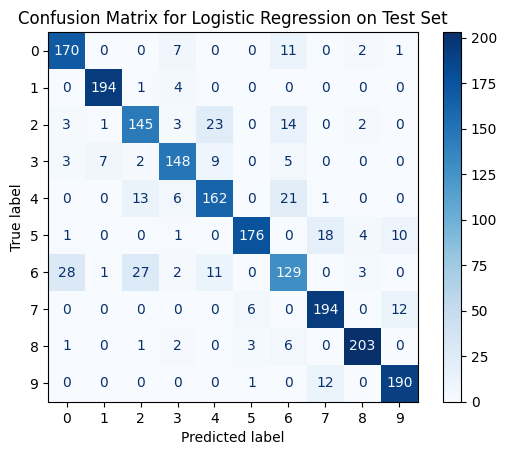

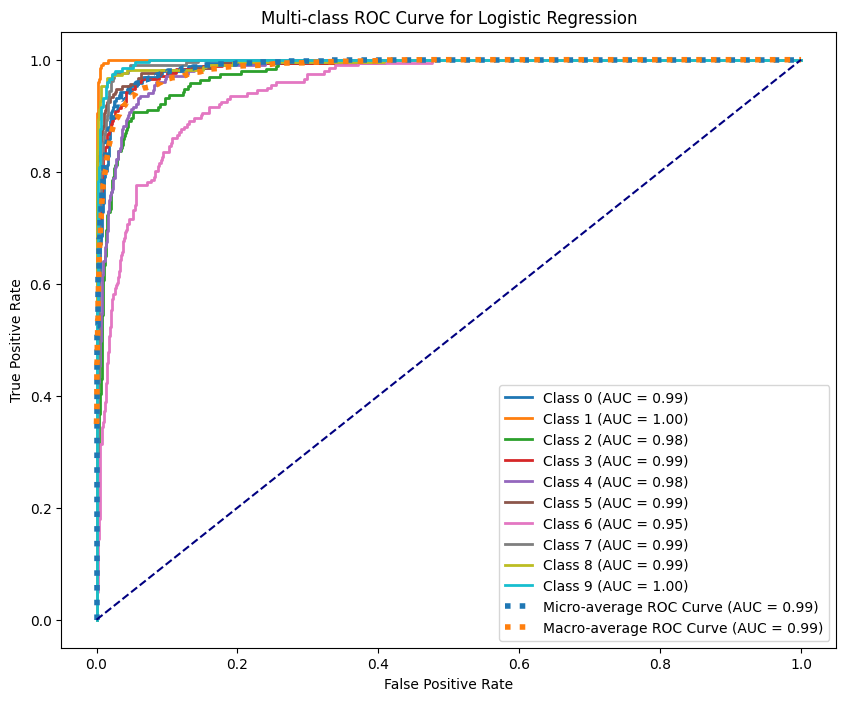

Performance for Bagging with SVM on Validation Set:
Accuracy: 0.8850, Precision: 0.8846, Recall: 0.8850, F1 Score: 0.8846
Training Time: 38.9829s, Inference Time (Validation): 5.4183s
Performance for Bagging with SVM on Test Set:
Accuracy: 0.8945, Precision: 0.8943, Recall: 0.8945, F1 Score: 0.8941
Inference Time (Test): 1.7777s


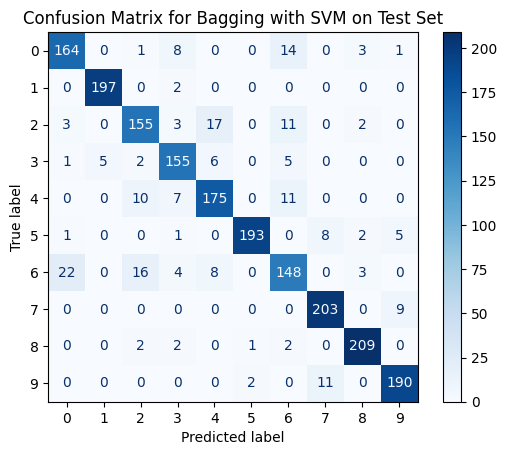

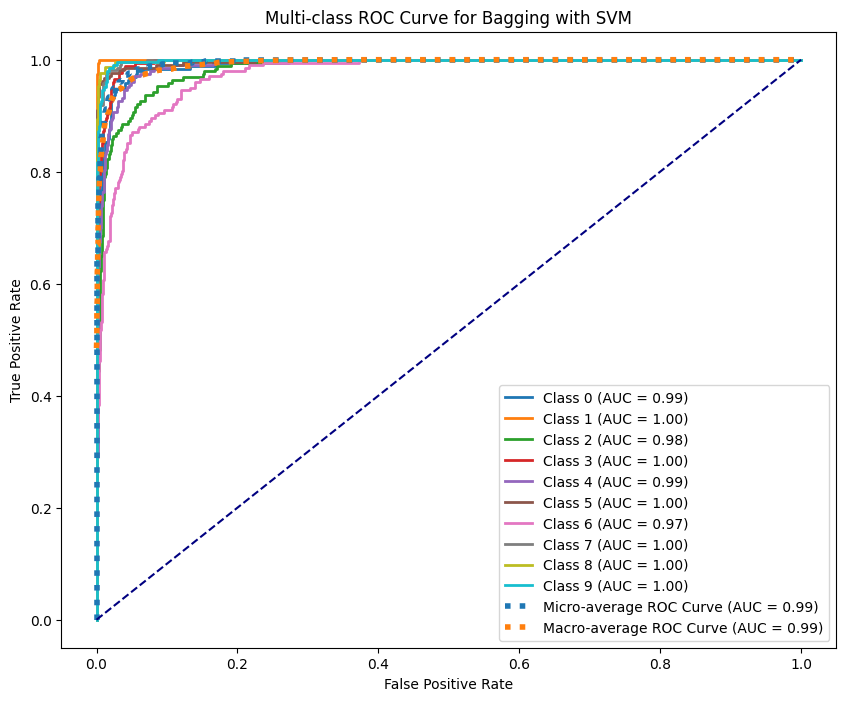

                 Model  Accuracy (Val)  Precision (Val)  Recall (Val)  \
0                  KNN        0.858167         0.857715      0.858167   
1                  SVM        0.885000         0.884562      0.885000   
2        Decision Tree        0.741167         0.741665      0.741167   
3  Logistic Regression        0.846500         0.846146      0.846500   
4     Bagging with SVM        0.885000         0.884642      0.885000   

   F1 Score (Val)  Accuracy (Test)  Precision (Test)  Recall (Test)  \
0        0.857338           0.8625          0.863052         0.8625   
1        0.884604           0.8990          0.898973         0.8990   
2        0.740935           0.7430          0.739622         0.7430   
3        0.846143           0.8555          0.855245         0.8555   
4        0.884634           0.8945          0.894276         0.8945   

   F1 Score (Test)  Training Time (s)  Inference Time (Val) (s)  \
0         0.861499           0.004304                  0.249606   


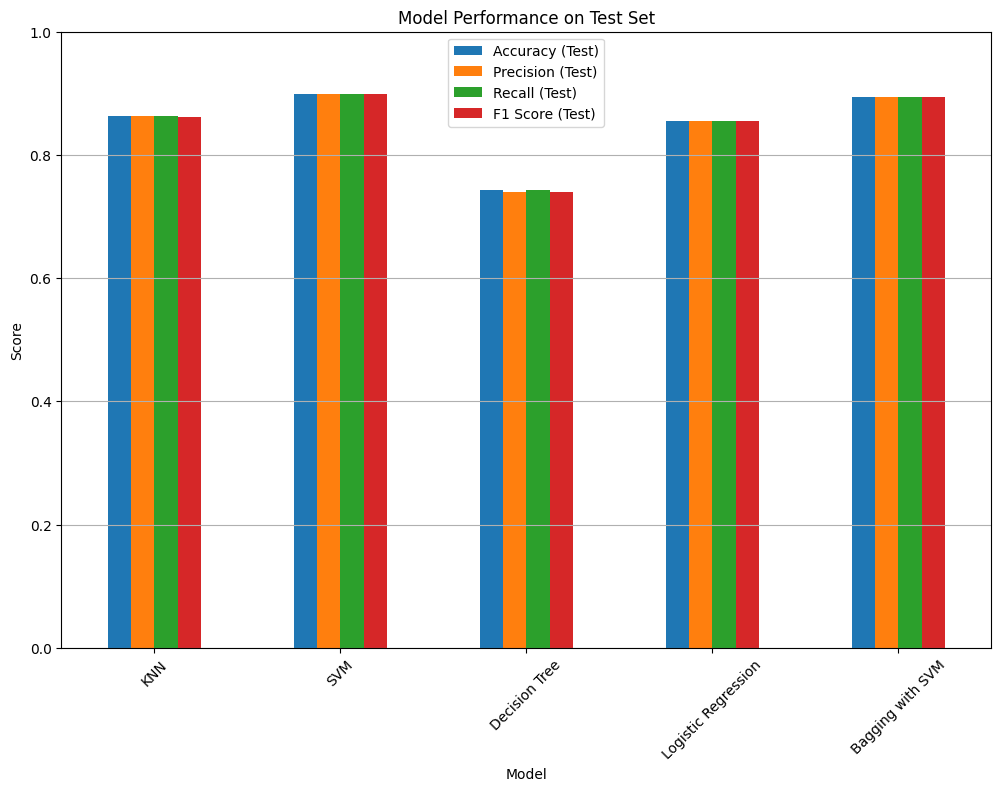

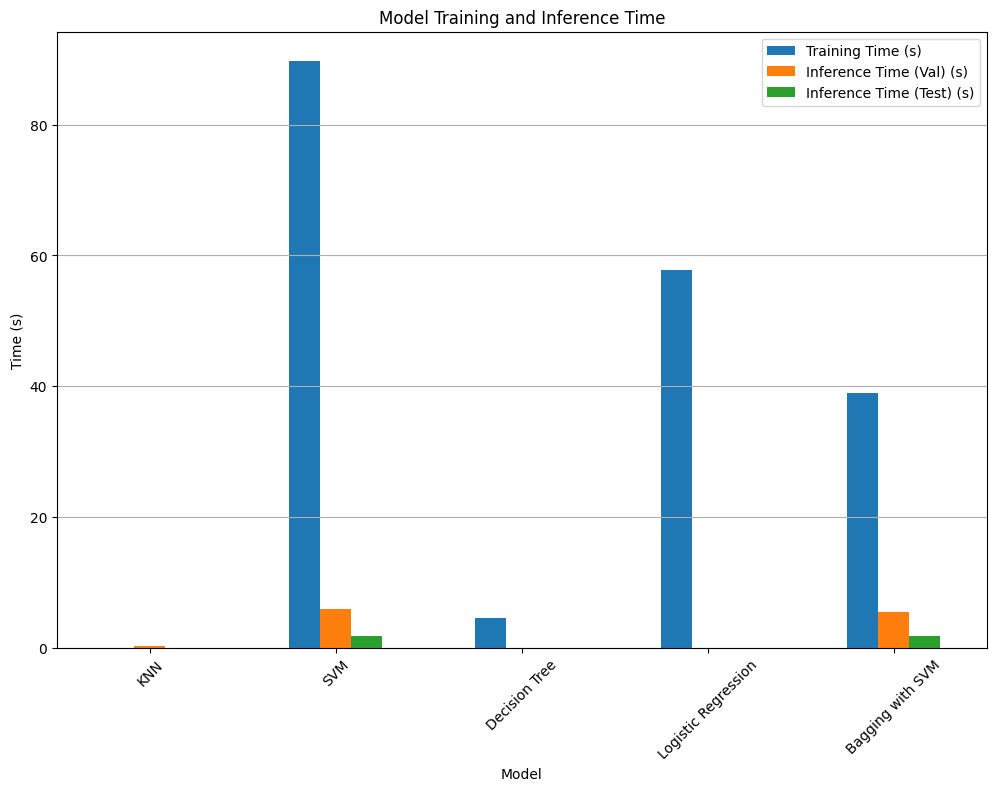

In [123]:
def evaluate_model(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, model_name):
    # Time: train
    start_train_time = time.time()
    model.fit(X_train, Y_train)
    end_train_time = time.time()
    training_time = end_train_time - start_train_time

    # Time: validation
    start_inference_time_val = time.time()
    y_val_pred = model.predict(X_val)
    end_inference_time_val = time.time()
    inference_time_val = end_inference_time_val - start_inference_time_val

    y_val_prob = model.predict_proba(X_val) if hasattr(model, "predict_proba") else None

    # Time: test
    start_inference_time_test = time.time()
    y_test_pred = model.predict(X_test)
    end_inference_time_test = time.time()
    inference_time_test = end_inference_time_test - start_inference_time_test

    y_test_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Performance metrics: Validation
    accuracy_val = accuracy_score(Y_val, y_val_pred)
    f1_val = f1_score(Y_val, y_val_pred, average='weighted')
    precision_val = precision_score(Y_val, y_val_pred, average='weighted')
    recall_val = recall_score(Y_val, y_val_pred, average='weighted')

    # Performance metrics: test
    accuracy_test = accuracy_score(Y_test, y_test_pred)
    f1_test = f1_score(Y_test, y_test_pred, average='weighted')
    precision_test = precision_score(Y_test, y_test_pred, average='weighted')
    recall_test = recall_score(Y_test, y_test_pred, average='weighted')

    # Output
    print(f"Performance for {model_name} on Validation Set:")
    print(f"Accuracy: {accuracy_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")
    print(f"Training Time: {training_time:.4f}s, Inference Time (Validation): {inference_time_val:.4f}s")

    print(f"Performance for {model_name} on Test Set:")
    print(f"Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")
    print(f"Inference Time (Test): {inference_time_test:.4f}s")

    # Confusion matrix
    cm_test = confusion_matrix(Y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name} on Test Set')
    plt.show()

    # ROC & AUC for Multiclass
    if y_test_prob is not None:
        # Binarize
        classes = np.unique(Y_test)
        Y_test_binarized = label_binarize(Y_test, classes=classes)
        n_classes = len(classes)

        # Calculate ROC curve & AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        plt.figure(figsize=(10, 8))

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_test_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

        # Compute microaverage ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_binarized.ravel(), y_test_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=4, label=f'Micro-average ROC Curve (AUC = {roc_auc["micro"]:.2f})')

        # Compute macroaverage ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=4, label=f'Macro-average ROC Curve (AUC = {roc_auc["macro"]:.2f})')

        # Plot diagonal line
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multi-class ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    return {
        'Model': model_name,
        'Accuracy (Val)': accuracy_val,
        'Precision (Val)': precision_val,
        'Recall (Val)': recall_val,
        'F1 Score (Val)': f1_val,
        'Accuracy (Test)': accuracy_test,
        'Precision (Test)': precision_test,
        'Recall (Test)': recall_test,
        'F1 Score (Test)': f1_test,
        'Training Time (s)': training_time,
        'Inference Time (Val) (s)': inference_time_val,
        'Inference Time (Test) (s)': inference_time_test
    }

# Evaluate each model and collect results
results = []
results.append(evaluate_model(knn, x_encoded, Y_train, x_valid_encoded, Y_val, x_test_encoded, Y_test, 'KNN'))
results.append(evaluate_model(svm, x_encoded, Y_train, x_valid_encoded, Y_val, x_test_encoded, Y_test, 'SVM'))
results.append(evaluate_model(decision_tree, x_encoded, Y_train, x_valid_encoded, Y_val, x_test_encoded, Y_test, 'Decision Tree'))
results.append(evaluate_model(lr, x_encoded, Y_train, x_valid_encoded, Y_val, x_test_encoded, Y_test, 'Logistic Regression'))
results.append(evaluate_model(bagging_svm, x_encoded, Y_train, x_valid_encoded, Y_val, x_test_encoded, Y_test, 'Bagging with SVM'))

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Plotting: performance metrics
metrics = ['Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)']
results_df.set_index('Model')[metrics].plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance on Test Set')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

# Plotting: training and inference time
time_metrics = ['Training Time (s)', 'Inference Time (Val) (s)', 'Inference Time (Test) (s)']
results_df.set_index('Model')[time_metrics].plot(kind='bar', figsize=(12, 8))
plt.title('Model Training and Inference Time')
plt.ylabel('Time (s)')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


In [124]:
output = svm_best.predict(x_test_encoded_2)
output_df = pd.DataFrame(output, columns = ['label'])
output_df.to_csv('/content/test_output.csv', sep=",", float_format='%d',index_label="id")